# Symmetrisierte Daten

Wenn man die Daten auf die ganze reziproke Gitterzelle fortsetzt, kann man das Gradient Descent auch ohne eingebaute Symmetrie verwenden. Dabei kommen deutlich bessere Modelle raus.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import importlib
np.set_printoptions(precision=3, suppress=True)
# finalized libs
from bandstructure import *
from symmetry import *
# not finalized libs
import fermi_surface as fs
importlib.reload(fs)
import density_of_states as dos
importlib.reload(dos);

Symmetries: 48
found inversion symmetry
final loss: 1.20e-01 (max band-error [0.106 0.105 0.106 0.218 0.119 0.301 0.141 0.146 0.14  0.196 0.225 0.314])
final loss: 7.70e-02 (max band-error [0.047 0.073 0.121 0.173 0.116 0.278 0.117 0.106 0.1   0.151 0.131 0.455])


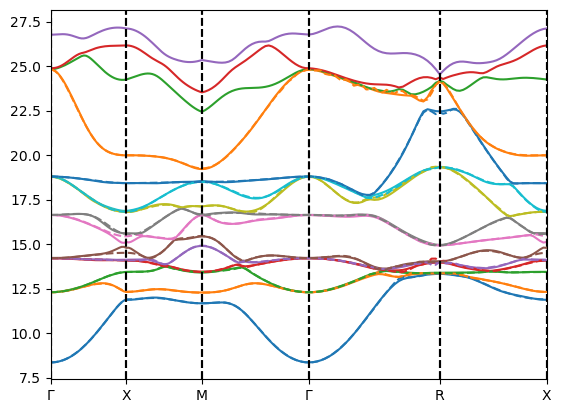

In [10]:
# read the data from Bandx.dat from Quantum Espresso
import qespresso_interface as qe
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, _, ref_bands, symmetries, fermi_energy = material.read_bands()
print("Symmetries:", len(symmetries))
ref_bands = ref_bands[:,8:]
k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(k_smpl, ref_bands)

# now start my algorithm to find good matrices
additional_bands = 3
band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.5
weights[-1] = 1.0

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1)) # works well
neighbors = Symmetry.cubic(True).complete_neighbors(neighbors)

tb_nitinol = BandStructureModel.init_tight_binding_from_ref(Symmetry.none(), neighbors, k_smpl, ref_bands, band_offset, additional_bands, cos_reduced=True)
tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 1000, 32, train_k0=False, regularization=0.99)
tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 2000, 32, train_k0=True, regularization=0.999)

import kpaths
path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
#plt.ylim(8, 24)
plt.show()

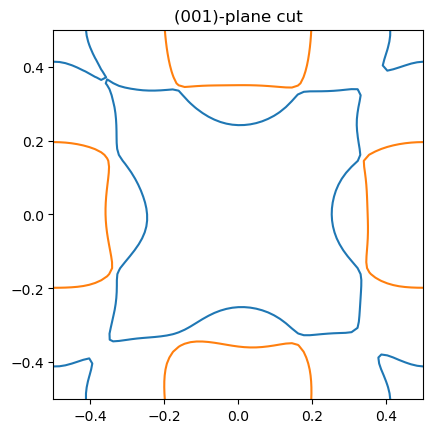

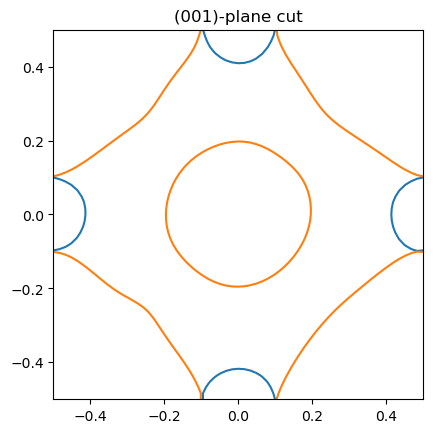

In [11]:
fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy, N=63)

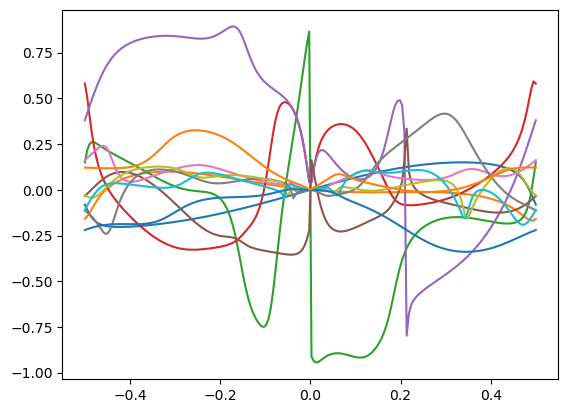

In [12]:
# plot how the unitary rotation matrices behave by plotting
# a few components of the matrices along a k-line
k_x = np.linspace(-0.5, 0.5, 200)
k_line = k_x[:,None] * np.array([[1, 0, 0]]) + np.array([[1, 1, 1]]) * 0.0
Uk = np.linalg.eigh(tb_nitinol.f(k_line))[1]
for i in range(6):
    plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,1,i] / Uk[:,0,i]))
    plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,2,i] / Uk[:,0,i]))
plt.show()

Now do the same for copper, which has a different cell shape, but again cubic symmetry.

In [5]:
# read the data from Bandx.dat from Quantum Espresso
import qespresso_interface as qe
material = qe.QECrystal("cu", [], [], [], 0)
k_smpl, _, ref_bands, symmetries, fermi_energy = material.read_bands()
print("Symmetries:", len(symmetries))
k_smpl, ref_bands = Symmetry.cubic(True).realize_symmetric_data(k_smpl, ref_bands)

# now start my algorithm to find good matrices
additional_bands = 3
band_offset = 1 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.1
weights[-1] = 0.1
weights[-2] = 0.1

basis_transform = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]]) / 2.0
neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1))
neighbors = Symmetry.cubic(True).complete_neighbors(neighbors) # this can be done before or after the basis_transform is applied for different results
neighbors = np.array(neighbors) @ basis_transform

tb_cu = BandStructureModel.init_tight_binding_from_ref(Symmetry.none(), neighbors, k_smpl, ref_bands, band_offset, additional_bands, cos_reduced=True)
tb_cu.optimize(k_smpl, 1, ref_bands, weights, band_offset, 1000, 21, train_k0=False, regularization=0.995, learning_rate=0.25)
tb_cu.optimize(k_smpl, 1, ref_bands, weights, band_offset, 2000, 21, train_k0=True, regularization=0.999, learning_rate=0.25)

Symmetries: 48
final loss: 6.03e-01 (max band-error [2.284 1.047 0.564 0.491 0.702 5.069 1.118 4.017])])
final loss: 1.73e-01 (max band-error [0.421 0.275 0.205 0.212 0.201 0.371 0.557 1.723])


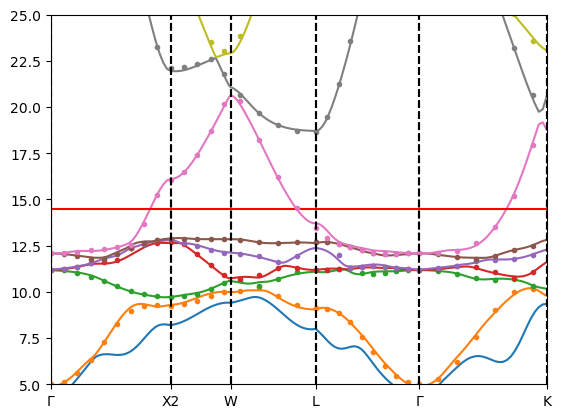

In [6]:
import kpaths
importlib.reload(kpaths)
path = kpaths.KPath('G').to('X2').to('W').to('L').to('G').to('K')
path2 = kpaths.KPath('G').to('X2', 9).to('W', 9).to('L', 9).to('G', 9).to('K', 9*3)
interpolator = kpaths.interpolate_unstructured(k_smpl, ref_bands, Symmetry.none())
path.plot(tb_cu, '-')
plt.axhline(fermi_energy, color='r')
path2.plot(interpolator, '.', band_offset=1)
plt.ylim(5, 25)
plt.show()

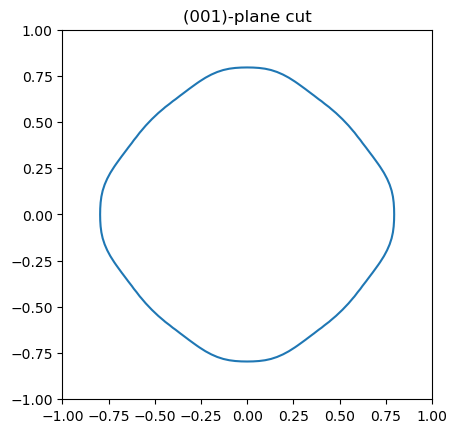

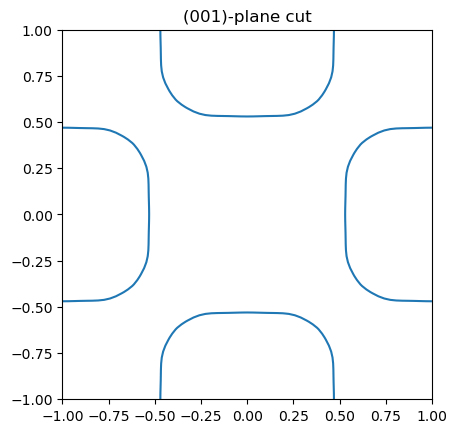

In [20]:
fs.plot_2D_fermi_surface(tb_cu, fermi_energy, N=63, k_range=[-1, 1])